# **Imports**

In [ ]:
!pip install ultralytics
from google.colab import drive
import os
import shutil
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import torch

drive.mount('/content/drive')

Mounted at /content/drive


 # **Dataset Loading**

In [ ]:
BASE_DIR = '/content/sar_project'
os.makedirs(f'{BASE_DIR}/images/train', exist_ok=True)
os.makedirs(f'{BASE_DIR}/images/val', exist_ok=True)
os.makedirs(f'{BASE_DIR}/labels/train', exist_ok=True)
os.makedirs(f'{BASE_DIR}/labels/val', exist_ok=True)

# Unzip images and labels

!unzip -q /content/drive/MyDrive/images_ship_detection.zip -d /content/temp_images
!unzip -q /content/drive/MyDrive/labels_ship_detection.zip -d /content/temp_labels

image_files = sorted([f for f in os.listdir('/content/temp_images/images') if f.endswith('.jpg')])
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

def move_files(files, split):
    for f in files:
        shutil.move(f'/content/temp_images/images/{f}', f'{BASE_DIR}/images/{split}/{f}')
        label_name = f.replace('.jpg', '.txt')
        shutil.move(f'/content/temp_labels/labels/{label_name}', f'{BASE_DIR}/labels/{split}/{label_name}')

move_files(train_files, 'train')
move_files(val_files, 'val')

print(f"Dataset ready: {len(train_files)} training images, {len(val_files)} validation images.")

Dataset ready: 3179 training images, 795 validation images.


In [ ]:
import yaml

config = {
    'path': BASE_DIR,
    'train': 'images/train',
    'val': 'images/val',
    'nc': 1,
    'names': ['ship']
}

with open(f'{BASE_DIR}/sar_data.yaml', 'w') as f:
    yaml.dump(config, f)

# **YOLOv26n Training**

In [ ]:
import os
import torch
from ultralytics import YOLO

GOOGLE_DRIVE_PATH = '/content/drive/MyDrive/YOLO26_SAR_Project'
os.makedirs(GOOGLE_DRIVE_PATH, exist_ok=True)

checkpoint_path = os.path.join(GOOGLE_DRIVE_PATH, 'ship_detection/weights/last.pt')

if os.path.exists(checkpoint_path):
    print(f"--- Found existing checkpoint at {checkpoint_path}. Resuming... ---")
    model = YOLO(checkpoint_path)
    results = model.train(resume=True)
else:
    print("--- No checkpoint found. Starting fresh training... ---")
    model = YOLO('yolo26n.pt')
    results = model.train(
        data=f'{BASE_DIR}/sar_data.yaml',
        epochs=100,
        imgsz=640,
        batch=16,
        project=GOOGLE_DRIVE_PATH,
        name='ship_detection',
        exist_ok=True
    )

best_model_path = os.path.join(GOOGLE_DRIVE_PATH, 'ship_detection/weights/best.pt')
best_model = YOLO(best_model_path)

# Extracting the state_dict
torch.save(best_model.model.state_dict(), f'{GOOGLE_DRIVE_PATH}/yolo26n_sar_state_dict.pth')

print("-" * 30)
print(f"DONE! Final weights saved to Drive:")
print(f"1. Ultralytics format: {best_model_path}")
print(f"2. Raw state_dict: {GOOGLE_DRIVE_PATH}/yolo26n_sar_state_dict.pth")

--- No checkpoint found. Starting fresh training... ---
Ultralytics 8.4.13 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/sar_project/sar_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo26n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=ship_detection, nbs=64, nms=False, opset=None, optimiz

# **Visualization**

Running inference on 50 images...


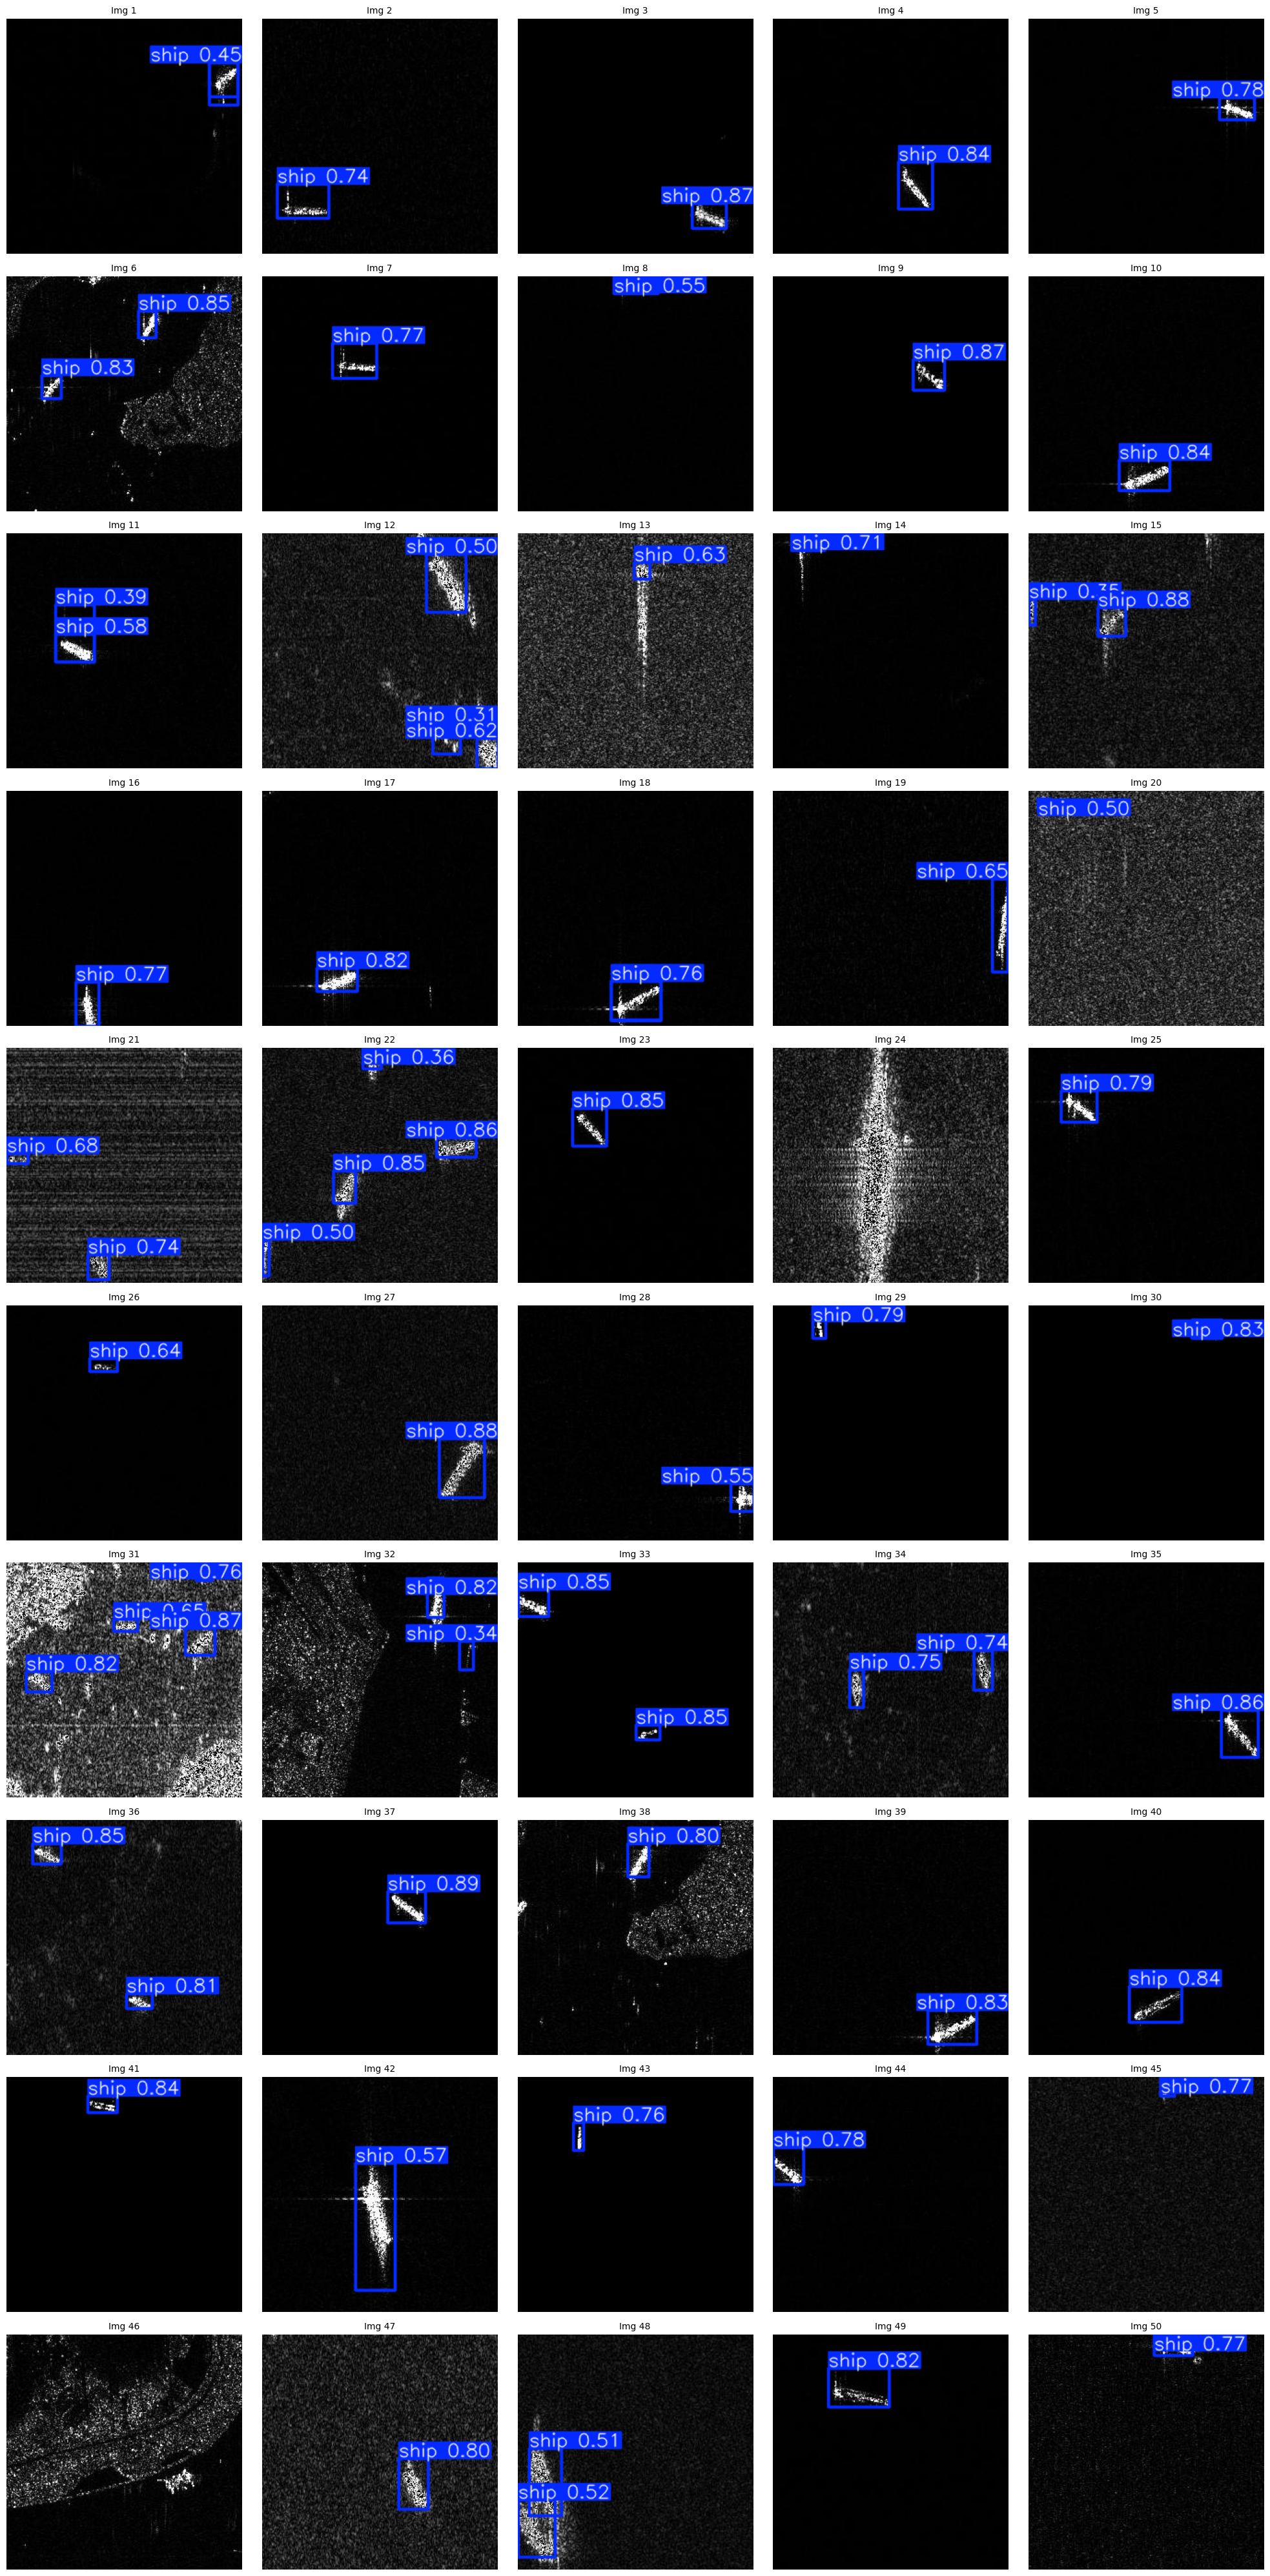

In [ ]:
import matplotlib.pyplot as plt
import cv2
import glob
import math

# 1. Load the Best Model
best_model_path = os.path.join(GOOGLE_DRIVE_PATH, 'ship_detection/weights/best.pt')
model = YOLO(best_model_path)

# 2. Get 50 Images from Validation Set
val_images = glob.glob(f'{BASE_DIR}/images/val/*.jpg')[:50] # Limit to 50
print(f"Running inference on {len(val_images)} images...")

# 3. Run Batch Prediction
results = model.predict(source=val_images, conf=0.25, save=False, verbose=False)

# 4. Visualization Config (Grid of 5 columns x 10 rows)
cols = 5
rows = math.ceil(len(val_images) / cols)
plt.figure(figsize=(20, 4 * rows)) # Adjust height based on rows

for i, r in enumerate(results):
    # Plot the bounding boxes on the image
    img_plotted = r.plot()

    # Convert BGR (OpenCV) to RGB (Matplotlib)
    img_rgb = cv2.cvtColor(img_plotted, cv2.COLOR_BGR2RGB)

    # Create Subplot
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Img {i+1}", fontsize=10)

plt.tight_layout()
plt.show()

# **ONNX Conversion FP32**

In [ ]:
import os
import shutil
from ultralytics import YOLO

# Path to the BEST weights in your Drive
BEST_MODEL_DRIVE = os.path.join(GOOGLE_DRIVE_PATH, 'ship_detection/weights/best.pt')

if os.path.exists(BEST_MODEL_DRIVE):
    model = YOLO(BEST_MODEL_DRIVE)

    model.export(
        format='onnx',
        simplify=True,
        data=f'{BASE_DIR}/sar_data.yaml',
        imgsz=640
    )

    # Ultralytics saves the export in the same folder as the weights
    exported_onnx_path = BEST_MODEL_DRIVE.replace('.pt', '.onnx')

    DEPLOY_FOLDER = os.path.join(GOOGLE_DRIVE_PATH, 'ONNX_PTH_Files')
    os.makedirs(DEPLOY_FOLDER, exist_ok=True)

    # Move the ONNX to your deployment folder
    if os.path.exists(exported_onnx_path):
        shutil.copy(exported_onnx_path, os.path.join(DEPLOY_FOLDER, 'yolo26n_sar_fp32.onnx'))

    # Copy the .pth state_dict we created earlier
    pth_source = f'{GOOGLE_DRIVE_PATH}/yolo26n_sar_state_dict.pth'
    if os.path.exists(pth_source):
        shutil.copy(pth_source, os.path.join(DEPLOY_FOLDER, 'yolo26n_sar_state_dict.pth'))

    print("-" * 30)
    print(f"--- SUCCESS ---")
    print(f"Deployment files are ready in: {DEPLOY_FOLDER}")
else:
    print("Error: Best weights not found in Drive.")

--- Exporting to Clean ONNX for FINN/Hardware ---
Ultralytics 8.4.13 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLO26n summary (fused): 122 layers, 2,375,031 parameters, 0 gradients, 5.2 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/YOLO26_SAR_Project/ship_detection/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 6) (5.1 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<2.0.0', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 12 packages in 144ms
Prepared 4 packages in 11.22s
Installed 4 packages in 269ms
 + colorama==0.4.6
 + onnx==1.20.1
 + onnxruntime-gpu==1.24.1
 + onnxslim==0.1.84

requirements: AutoUpdate success ✅ 12.2s
WARNING ⚠️ requirements: Restart runtime or rerun command for updat

/usr/local/lib/python3.12/dist-packages/torch/onnx/_internal/torchscript_exporter/utils.py:1447: OnnxExporterWarning: Exporting to ONNX opset version 22 is not supported. by 'torch.onnx.export()'. The highest opset version supported is 20. To use a newer opset version, consider 'torch.onnx.export(..., dynamo=True)'. 
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/onnx/_internal/torchscript_exporter/symbolic_opset9.py:5353: UserWarning: Exporting aten::index operator of advanced indexing in opset 22 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, and Gather. If indices include negative values, the exported graph will produce incorrect results.
  warnings.warn(


ONNX: slimming with onnxslim 0.1.84...
ONNX: export success ✅ 15.3s, saved as '/content/drive/MyDrive/YOLO26_SAR_Project/ship_detection/weights/best.onnx' (9.4 MB)

Export complete (15.8s)
Results saved to /content/drive/MyDrive/YOLO26_SAR_Project/ship_detection/weights
Predict:         yolo predict task=detect model=/content/drive/MyDrive/YOLO26_SAR_Project/ship_detection/weights/best.onnx imgsz=640 
Validate:        yolo val task=detect model=/content/drive/MyDrive/YOLO26_SAR_Project/ship_detection/weights/best.onnx imgsz=640 data=/content/sar_project/sar_data.yaml  
Visualize:       https://netron.app
------------------------------
--- SUCCESS ---
Deployment files are ready in: /content/drive/MyDrive/YOLO26_SAR_Project/PYNQ_Deployment
Note: Provide the .onnx and .pth to your team for FINN quantization.


In [ ]:
# Install the quantization tool
!pip install -q onnxruntime onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 21.6 MB/s eta 0:00:00


# **Quantization (INT8) and ONNX Conversion**

In [ ]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType
import os
import shutil

# 1. Export as Standard FP32 ONNX first (Clean Export)
print("--- Step 1: Exporting Standard FP32 ONNX ---")
model.export(
    format='onnx',
    simplify=True,
    data=f'{BASE_DIR}/sar_data.yaml',
    imgsz=640
)

# Define paths
fp32_path = best_model_path.replace('.pt', '.onnx')
int8_path = best_model_path.replace('.pt', '_int8_quantized.onnx')

# 2. Perform Manual INT8 Quantization
print(f"\n--- Step 2: Quantizing {fp32_path} to INT8 ---")

if os.path.exists(fp32_path):
    quantize_dynamic(
        model_input=fp32_path,
        model_output=int8_path,
        weight_type=QuantType.QUInt8 # Quantize weights to Unsigned INT8
    )
    print("Quantization Complete!")

    # 3. Move to Deployment Folder
    DEPLOY_FOLDER = os.path.join(GOOGLE_DRIVE_PATH, 'ONNX_PTH_Files')
    os.makedirs(DEPLOY_FOLDER, exist_ok=True)

    final_dest = os.path.join(DEPLOY_FOLDER, 'yolo26n_sar_int8.onnx')
    shutil.copy(int8_path, final_dest)

    # Also copy the FP32 version
    shutil.copy(fp32_path, os.path.join(DEPLOY_FOLDER, 'yolo26n_sar_fp32.onnx'))

    print("-" * 30)
    print(f"SUCCESS: INT8 Model saved at: {final_dest}")
    print(f"Size Check: {os.path.getsize(fp32_path)/1024/1024:.2f} MB (FP32) -> {os.path.getsize(int8_path)/1024/1024:.2f} MB (INT8)")
else:
    print("Error: FP32 Export failed. Check previous steps.")

--- Step 1: Exporting Standard FP32 ONNX ---
Ultralytics 8.4.13 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)

PyTorch: starting from '/content/drive/MyDrive/YOLO26_SAR_Project/ship_detection/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 6) (5.1 MB)

ONNX: starting export with onnx 1.20.1 opset 22...
ONNX: slimming with onnxslim 0.1.84...
ONNX: export success ✅ 1.4s, saved as '/content/drive/MyDrive/YOLO26_SAR_Project/ship_detection/weights/best.onnx' (9.4 MB)

Export complete (1.8s)
Results saved to /content/drive/MyDrive/YOLO26_SAR_Project/ship_detection/weights
Predict:         yolo predict task=detect model=/content/drive/MyDrive/YOLO26_SAR_Project/ship_detection/weights/best.onnx imgsz=640 
Validate:        yolo val task=detect model=/content/drive/MyDrive/YOLO26_SAR_Project/ship_detection/weights/best.onnx imgsz=640 data=/content/sar_project/sar_data.yaml  
Visualize:       https://netron.app

--- Step 2: Quantizing /cont

Quantization Complete!
------------------------------
SUCCESS: INT8 Model saved at: /content/drive/MyDrive/YOLO26_SAR_Project/PYNQ_Deployment/yolo26n_sar_int8.onnx
Size Check: 9.35 MB (FP32) -> 2.74 MB (INT8)


# **Quantization Evaluation**

In [ ]:
import os
import pandas as pd
from ultralytics import YOLO

fp32_path = os.path.join(GOOGLE_DRIVE_PATH, 'ship_detection/weights/best.pt')
int8_path = os.path.join(GOOGLE_DRIVE_PATH, 'ONNX_PTH_Files/yolo26n_sar_int8.onnx')

print(f"Analyzing Models:\n1. FP32: {fp32_path}\n2. INT8: {int8_path}\n")

# --- MODEL SIZE CHECK ---
size_fp32 = os.path.getsize(fp32_path) / (1024 * 1024) # MB
size_int8 = os.path.getsize(int8_path) / (1024 * 1024) # MB
size_reduction = (1 - (size_int8 / size_fp32)) * 100

# --- VALIDATION RUNS ---
# Load FP32 (Original PyTorch)
print("-" * 40)
print("Running FP32 Validation (Original)...")
model_fp32 = YOLO(fp32_path)
metrics_fp32 = model_fp32.val(data=f'{BASE_DIR}/sar_data.yaml', imgsz=640, verbose=False)

# Load INT8 (Quantized ONNX)
print("-" * 40)
print("Running INT8 Validation (Quantized)...")
model_int8 = YOLO(int8_path, task='detect')
metrics_int8 = model_int8.val(data=f'{BASE_DIR}/sar_data.yaml', imgsz=640, verbose=False)

# --- 3. METRIC EXTRACTION ---
def get_loss(metrics):
    try:
        return metrics.loss if metrics.loss else [0, 0, 0]
    except:
        return [0, 0, 0]

loss_fp32 = get_loss(metrics_fp32)
loss_int8 = get_loss(metrics_int8) # [0,0,0] for ONNX

# Speed
speed_fp32 = metrics_fp32.speed['inference']
speed_int8 = metrics_int8.speed['inference']

# --- FINAL COMPARISON REPORT ---
results = {
    'Metric': ['Model Size (MB)', 'mAP@50', 'mAP@50-95', 'Inference Time (ms)', 'Box Loss', 'Cls Loss'],
    'FP32 (Original)': [
        f"{size_fp32:.2f}",
        f"{metrics_fp32.box.map50:.4f}",
        f"{metrics_fp32.box.map:.4f}",
        f"{speed_fp32:.2f}",
        f"{loss_fp32[0]:.4f}",
        f"{loss_fp32[1]:.4f}"
    ],
    'INT8 (Quantized)': [
        f"{size_int8:.2f}",
        f"{metrics_int8.box.map50:.4f}",
        f"{metrics_int8.box.map:.4f}",
        f"{speed_int8:.2f}",
        "N/A (Inference Only)",
        "N/A (Inference Only)"
    ]
}

df = pd.DataFrame(results)

print("\n" + "="*50)
print("   QUANTIZATION PERFORMANCE REPORT   ")
print("="*50)
print(df.to_string(index=False))
print("-" * 50)

# --- AUTOMATIC PASS/FAIL CHECK ---
drop_map50 = metrics_fp32.box.map50 - metrics_int8.box.map50
print(f"\nSize Reduction: {size_reduction:.2f}%")
print(f"mAP@50 Drop:    {drop_map50:.4f}")

if drop_map50 > 0.05:
    print("\n❌ CRITICAL WARNING: High Accuracy Drop (>5%)")
    print("Recommendation: The dynamic quantization degraded the model too much.")
    print("Action: Attempt 'Static Quantization' with a calibration dataset or use QAT.")
else:
    print("\n✅ SUCCESS: Model is optimized and safe for FPGA deployment.")

Analyzing Models:
1. FP32: /content/drive/MyDrive/YOLO26_SAR_Project/ship_detection/weights/best.pt
2. INT8: /content/drive/MyDrive/YOLO26_SAR_Project/PYNQ_Deployment/yolo26n_sar_int8.onnx

----------------------------------------
Running FP32 Validation (Original)...
Ultralytics 8.4.13 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO26n summary (fused): 122 layers, 2,375,031 parameters, 0 gradients, 5.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 368.4±268.8 MB/s, size: 13.0 KB)
val: Scanning /content/sar_project/labels/val.cache... 795 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 795/795 166.7Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 5.3it/s 9.4s
                   all        795       1030      0.907      0.872      0.932      0.564
Speed: 1.9ms preprocess, 4.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /content/runs/detect/val2
-------